# Beam Steering with Evolution Strategies + Neural Networks

## Project Overview
Train a conditional neural network to generate optimal 8×8 photonic rod designs for arbitrary steering angles, using Evolution Strategies (ES) with ceviche as the physics simulator.

## Experiments
| ID | Method | Description |
|----|--------|-------------|
| Random | Baseline | Sample N random designs, report best |
| ES-0°, ES-90°, ES-180° | ES only | Optimize 64 rods for single angle |
| ES-Multi | ES only | One design optimized for all 3 angles |
| ES+NN | ES + Neural Net | NN takes angle θ → outputs 64 rods |

## Key Hypothesis
ES+NN can learn to produce angle-specific designs AND generalize to unseen angles.

---

In [13]:
# Imports and path setup
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add local ceviche to path (development version)
sys.path.insert(0, '/Users/sze/project-lorentz/ceviche')

import ceviche
from ceviche import fdfd_ez
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

print(f"Ceviche version: {ceviche.__version__}")
print("Setup complete!")

Ceviche version: 0.1.3
Setup complete!


## Part 1: Simulation Parameters - Microwave Lab Setup

Physical parameters matching the real plasma metamaterial array:
- **Frequency**: 3.75 GHz (λ ≈ 8 cm)
- **Rod diameter**: 2 cm
- **Rod spacing**: 2.1 cm (center-to-center)
- **Array size**: 8×8 rods = 64 binary parameters

In [91]:
# =============================================================================
# SIMULATION PARAMETERS - Microwave Lab Setup
# =============================================================================
# These parameters match the real plasma metamaterial array in the lab.
# See DESIGN_DECISIONS.md for full justification of each choice.

# -----------------------------------------------------------------------------
# Physical Constants
# -----------------------------------------------------------------------------
SPEED_OF_LIGHT = 3e8        # m/s
METAL_EPSILON = -1e4        # Large negative permittivity to simulate PEC (metal)

# -----------------------------------------------------------------------------
# Operating Frequency
# -----------------------------------------------------------------------------
# We choose 6 GHz based on analysis of rod/wavelength ratios:
#   - d/λ = 0.40 (sub-wavelength rods, clean scattering)
#   - a/λ = 0.42 (safely below Bragg condition of 0.5)
#   - At ρ=1: ε = -5.25 (strong but not extreme contrast)
# This matches Jesse's experimental setup.
FREQUENCY = 6e9             # 6 GHz microwave
WAVELENGTH = SPEED_OF_LIGHT / FREQUENCY  # ~8 cm
omega = 2 * np.pi * FREQUENCY  # Angular frequency (rad/s)

# -----------------------------------------------------------------------------
# Lab Hardware Parameters (FIXED - must match physical setup)
# -----------------------------------------------------------------------------
N_RODS = 8                  # 8×8 rod array
rod_diameter = 0.02         # Rod diameter: 2 cm
rod_radius_m = rod_diameter / 2  # Rod radius: 1 cm
a = 0.021                   # Lattice constant: 2.1 cm (center-to-center spacing)
                            # This is rod diameter (2cm) + gap (1mm)

# -----------------------------------------------------------------------------
# Plasma Frequency Parameters (from Jesse's characterization)
# -----------------------------------------------------------------------------
# Jesse's data shows plasma frequency is LINEAR with voltage:
#   - At V=0:  ω_p ≈ 0 GHz
#   - At V=30: ω_p ≈ 15 GHz
# We use ρ ∈ [0,1] as NORMALIZED PLASMA FREQUENCY (not electron density!)
# This gives us direct mapping: ρ → voltage → plasma frequency → permittivity

OMEGA_P_MAX = 2 * np.pi * 15e9   # Max plasma frequency: 15 GHz (at 30V)
RHO_LEVELS = 11                   # Discrete levels: 0.0, 0.1, 0.2, ..., 1.0

# -----------------------------------------------------------------------------
# Grid Resolution
# -----------------------------------------------------------------------------
res = 25                    # Grid points per lattice constant
dl = a / res                # Grid spacing in meters (~0.84 mm)
rod_radius_grid = int(rod_radius_m / dl)  # Rod radius in grid points (~11)
rod_spacing_grid = res      # Rod spacing = 1 lattice constant = res grid points

# -----------------------------------------------------------------------------
# Simulation Domain Layout
# -----------------------------------------------------------------------------
# Layout needs space for:
#   - Source waveguide on the left
#   - 8×8 rod array in the center  
#   - Receiver waveguides on right, top, and bottom
#
# We need extra space in Y for the top/bottom receiver waveguides.

Npml = 2 * res              # PML thickness: 2 lattice constants
source_gap = 2 * res        # Gap for source waveguide
receiver_gap = 2 * res      # Gap for receiver waveguides

# X direction: PML | source_wg | rods | receiver_wg | PML
Nx = 2 * Npml + source_gap + N_RODS * res + receiver_gap

# Y direction: PML | bottom_receiver_wg | rods | top_receiver_wg | PML
Ny = 2 * Npml + receiver_gap + N_RODS * res + receiver_gap

# -----------------------------------------------------------------------------
# Key Positions in Grid
# -----------------------------------------------------------------------------
# Source position (left side)
SOURCE_X = Npml + source_gap // 2
SOURCE_Y_CENTER = Ny // 2

# Rod array position (center of domain)
ROD_ARRAY_X0 = Npml + source_gap  # First rod column
ROD_ARRAY_Y0 = Npml + receiver_gap  # First rod row (bottom)

# Rod array boundaries (useful for placing receivers OUTSIDE)
ROD_ARRAY_X_END = ROD_ARRAY_X0 + (N_RODS - 1) * rod_spacing_grid + rod_radius_grid
ROD_ARRAY_Y_END = ROD_ARRAY_Y0 + (N_RODS - 1) * rod_spacing_grid + rod_radius_grid
ROD_ARRAY_Y_START = ROD_ARRAY_Y0 - rod_radius_grid

# Rod array center (for reference)
ROD_ARRAY_CENTER_X = ROD_ARRAY_X0 + (N_RODS - 1) * rod_spacing_grid // 2
ROD_ARRAY_CENTER_Y = ROD_ARRAY_Y0 + (N_RODS - 1) * rod_spacing_grid // 2

# Legacy variable (for backwards compatibility)
PROBE_X = ROD_ARRAY_X_END + res

# -----------------------------------------------------------------------------
# Waveguide Parameters (shared by source and receivers)
# -----------------------------------------------------------------------------
WAVEGUIDE_WIDTH = 2 * res           # Aperture width: 2 lattice constants (~4.2 cm)
PLATE_THICKNESS = 3                 # Metal plate thickness in grid points

# -----------------------------------------------------------------------------
# Source Waveguide (left side, horizontal)
# -----------------------------------------------------------------------------
SOURCE_WG_Y_TOP = SOURCE_Y_CENTER + WAVEGUIDE_WIDTH // 2
SOURCE_WG_Y_BOT = SOURCE_Y_CENTER - WAVEGUIDE_WIDTH // 2
# Legacy names for compatibility
WAVEGUIDE_Y_TOP = SOURCE_WG_Y_TOP
WAVEGUIDE_Y_BOT = SOURCE_WG_Y_BOT

# -----------------------------------------------------------------------------
# Receiver Waveguides (positioned OUTSIDE the rod array)
# -----------------------------------------------------------------------------
# Each receiver has:
#   - A waveguide (two parallel metal plates)
#   - A line receiver inside the waveguide
#   - Positioned just outside the rod array
#
# Design: Receiver waveguide length = half of source waveguide length
#         Receiver line is at the BACK of the waveguide (away from rods)

# Source waveguide length for reference
SOURCE_WG_LENGTH = source_gap  # = 2 * res = 50 grid points

# Receiver waveguide length = half of source
RECEIVER_WG_LENGTH = SOURCE_WG_LENGTH // 2  # = res = 25 grid points

RECEIVER_LINE_LENGTH = WAVEGUIDE_WIDTH - 4  # Line receiver length (inside waveguide)

# Distance from rod array boundary to waveguide opening (same for all receivers)
RECV_GAP = res // 2  # 12 grid points gap between rods and waveguide opening

# 90° Receiver: RIGHT of rod array (vertical waveguide, opens to the left)
RECV_90_X = ROD_ARRAY_X_END + RECV_GAP  # Just after last rod column
RECV_90_Y_CENTER = ROD_ARRAY_CENTER_Y
RECV_90_WG_X_START = RECV_90_X
RECV_90_WG_X_END = RECV_90_X + RECEIVER_WG_LENGTH

# 0° Receiver: BOTTOM of rod array (horizontal waveguide, opens upward)
RECV_0_Y = ROD_ARRAY_Y_START - RECV_GAP  # Just below first rod row
RECV_0_X_CENTER = ROD_ARRAY_CENTER_X
RECV_0_WG_Y_END = RECV_0_Y
RECV_0_WG_Y_START = RECV_0_Y - RECEIVER_WG_LENGTH

# 180° Receiver: TOP of rod array (horizontal waveguide, opens downward)
RECV_180_Y = ROD_ARRAY_Y_END + RECV_GAP  # Just above last rod row
RECV_180_X_CENTER = ROD_ARRAY_CENTER_X
RECV_180_WG_Y_START = RECV_180_Y
RECV_180_WG_Y_END = RECV_180_Y + RECEIVER_WG_LENGTH

# Receiver definitions dict
# NOTE: Receiver line is at the BACK of the waveguide (farthest from rods)
RECEIVERS = {
    0: {    # 0° = Down (-y direction)
        'name': 'Bottom',
        'type': 'horizontal_waveguide',  # Waveguide runs in Y direction
        'receiver_x': RECV_0_X_CENTER,
        'receiver_y': RECV_0_WG_Y_START + 2,  # At back of waveguide (+ small margin)
        'wg_x_center': RECV_0_X_CENTER,
        'wg_y_start': RECV_0_WG_Y_START,
        'wg_y_end': RECV_0_WG_Y_END,
        'line_orientation': 'horizontal',  # Receiver line runs along x
    },
    90: {   # 90° = Right (+x direction, straight through)
        'name': 'Right',
        'type': 'vertical_waveguide',  # Waveguide runs in X direction
        'receiver_x': RECV_90_WG_X_END - 2,  # At back of waveguide (- small margin)
        'receiver_y': RECV_90_Y_CENTER,
        'wg_x_start': RECV_90_WG_X_START,
        'wg_x_end': RECV_90_WG_X_END,
        'wg_y_center': RECV_90_Y_CENTER,
        'line_orientation': 'vertical',  # Receiver line runs along y
    },
    180: {  # 180° = Up (+y direction)
        'name': 'Top',
        'type': 'horizontal_waveguide',  # Waveguide runs in Y direction
        'receiver_x': RECV_180_X_CENTER,
        'receiver_y': RECV_180_WG_Y_END - 2,  # At back of waveguide (- small margin)
        'wg_x_center': RECV_180_X_CENTER,
        'wg_y_start': RECV_180_WG_Y_START,
        'wg_y_end': RECV_180_WG_Y_END,
        'line_orientation': 'horizontal',  # Receiver line runs along x
    },
}

RECEIVER_LENGTH = RECEIVER_LINE_LENGTH  # For compatibility

# -----------------------------------------------------------------------------
# Angle Definitions
# -----------------------------------------------------------------------------
# Convention: 0° = down (-y), 90° = right (+x, straight through), 180° = up (+y)
TRAINING_ANGLES = [0, 90, 180]        # Angles to optimize for (with receivers)
TEST_ANGLES = [30, 60, 90, 120, 150]  # Angles for generalization testing

# -----------------------------------------------------------------------------
# Print Summary
# -----------------------------------------------------------------------------
print("=" * 70)
print("SIMULATION PARAMETERS - Microwave Lab Setup")
print("=" * 70)
print(f"\n>>> Physical Parameters (fixed by lab hardware)")
print(f"    Operating frequency:  {FREQUENCY/1e9:.2f} GHz (λ = {WAVELENGTH*100:.1f} cm)")
print(f"    Rod array:            {N_RODS}×{N_RODS} = {N_RODS**2} rods")
print(f"    Rod diameter:         {rod_diameter*100:.1f} cm")
print(f"    Rod spacing:          {a*100:.1f} cm (center-to-center)")
print(f"    Max plasma freq:      {OMEGA_P_MAX/(2*np.pi*1e9):.1f} GHz (at 30V)")

print(f"\n>>> Grid Parameters")
print(f"    Resolution:           {res} points per lattice constant")
print(f"    Grid spacing:         {dl*1000:.2f} mm")
print(f"    Grid size:            {Nx} × {Ny} points")
print(f"    Physical size:        {Nx*dl*100:.1f} cm × {Ny*dl*100:.1f} cm")
print(f"    Rod radius:           {rod_radius_grid} grid points")

print(f"\n>>> Source Waveguide (left side)")
print(f"    Aperture width:       {WAVEGUIDE_WIDTH} grid points ({WAVEGUIDE_WIDTH*dl*100:.1f} cm)")
print(f"    Plate thickness:      {PLATE_THICKNESS} grid points")
print(f"    Waveguide Y range:    [{SOURCE_WG_Y_BOT}, {SOURCE_WG_Y_TOP}]")

print(f"\n>>> Control Parameter ρ (normalized plasma frequency)")
print(f"    Levels:               {RHO_LEVELS} discrete values (0.0 to 1.0)")
print(f"    Mapping:              ρ → ω_p = ρ × {OMEGA_P_MAX/(2*np.pi*1e9):.0f} GHz")
print(f"    Permittivity:         ε = 1 - (ω_p/ω)²")
print(f"    At ρ=0:               ε = 1.0 (air)")
print(f"    At ρ=1:               ε = {1 - (OMEGA_P_MAX/omega)**2:.1f} (full plasma)")

print(f"\n>>> Receiver Waveguides (OUTSIDE rod array)")
print(f"    Waveguide length:     {RECEIVER_WG_LENGTH} grid points ({RECEIVER_WG_LENGTH*dl*100:.1f} cm)")
print(f"    Receiver line length: {RECEIVER_LINE_LENGTH} grid points ({RECEIVER_LINE_LENGTH*dl*100:.1f} cm)")
print(f"    Training angles:      {TRAINING_ANGLES}")
for angle, info in RECEIVERS.items():
    rx, ry = info['receiver_x'], info['receiver_y']
    print(f"    {angle:3d}° ({info['name']:6s}):       receiver=({rx}, {ry}), {info['line_orientation']} line")
    print(f"                          waveguide: {info['type']}")
print("=" * 70)

SIMULATION PARAMETERS - Microwave Lab Setup

>>> Physical Parameters (fixed by lab hardware)
    Operating frequency:  6.00 GHz (λ = 5.0 cm)
    Rod array:            8×8 = 64 rods
    Rod diameter:         2.0 cm
    Rod spacing:          2.1 cm (center-to-center)
    Max plasma freq:      15.0 GHz (at 30V)

>>> Grid Parameters
    Resolution:           25 points per lattice constant
    Grid spacing:         0.84 mm
    Grid size:            400 × 400 points
    Physical size:        33.6 cm × 33.6 cm
    Rod radius:           11 grid points

>>> Source Waveguide (left side)
    Aperture width:       50 grid points (4.2 cm)
    Plate thickness:      3 grid points
    Waveguide Y range:    [175, 225]

>>> Control Parameter ρ (normalized plasma frequency)
    Levels:               11 discrete values (0.0 to 1.0)
    Mapping:              ρ → ω_p = ρ × 15 GHz
    Permittivity:         ε = 1 - (ω_p/ω)²
    At ρ=0:               ε = 1.0 (air)
    At ρ=1:               ε = -5.2 (full plasm

In [55]:
# =============================================================================
# PLASMA PHYSICS: ρ → Permittivity Mapping
# =============================================================================
# These functions implement the Drude model for plasma permittivity.
# See DESIGN_DECISIONS.md Section 2b for full physics explanation.

def rho_to_plasma_frequency(rho):
    """
    Convert normalized control parameter ρ to plasma frequency.
    
    PHYSICS:
    --------
    ρ represents the normalized plasma frequency (NOT electron density).
    This is a design choice because:
    1. ρ is linear with voltage (the lab control knob)
    2. Jesse's data shows ω_p ∝ V (linear relationship)
    
    Args:
        rho: Normalized plasma frequency ∈ [0, 1]
             0 = plasma off (V=0)
             1 = max plasma (V=30V, ω_p=15 GHz)
    
    Returns:
        omega_p: Plasma frequency in rad/s
    """
    return rho * OMEGA_P_MAX


def plasma_frequency_to_permittivity(omega_p):
    """
    Convert plasma frequency to permittivity using Drude model.
    
    PHYSICS:
    --------
    The Drude model gives: ε(ω) = 1 - (ω_p/ω)²
    
    - When ω < ω_p: ε < 0 → wave is evanescent (blocked/reflected)
    - When ω > ω_p: ε > 0 → wave propagates (with some refraction)
    - When ω = ω_p: ε = 0 → plasma resonance
    
    Args:
        omega_p: Plasma frequency in rad/s
    
    Returns:
        epsilon: Relative permittivity (can be negative!)
    """
    if omega_p == 0:
        return 1.0  # Air
    return 1.0 - (omega_p / omega) ** 2


def rho_to_permittivity(rho):
    """
    Full chain: ρ → plasma frequency → permittivity.
    
    This is the key function that converts our optimization variable (ρ)
    to the physical quantity ceviche needs (permittivity).
    
    Args:
        rho: Normalized plasma frequency ∈ [0, 1]
    
    Returns:
        epsilon: Relative permittivity
    """
    omega_p = rho_to_plasma_frequency(rho)
    return plasma_frequency_to_permittivity(omega_p)


# Quick test: show the mapping
print(f"ρ → ω_p → ε mapping (at f = {FREQUENCY/1e9:.1f} GHz):")
print("-" * 40)
for rho in [0.0, 0.2, 0.25, 0.3, 0.5, 0.7, 1.0]:
    omega_p = rho_to_plasma_frequency(rho)
    eps = rho_to_permittivity(rho)
    print(f"ρ = {rho:.2f}  →  ω_p = {omega_p/(2*np.pi*1e9):5.2f} GHz  →  ε = {eps:6.2f}")

ρ → ω_p → ε mapping (at f = 6.0 GHz):
----------------------------------------
ρ = 0.00  →  ω_p =  0.00 GHz  →  ε =   1.00
ρ = 0.20  →  ω_p =  3.00 GHz  →  ε =   0.75
ρ = 0.25  →  ω_p =  3.75 GHz  →  ε =   0.61
ρ = 0.30  →  ω_p =  4.50 GHz  →  ε =   0.44
ρ = 0.50  →  ω_p =  7.50 GHz  →  ε =  -0.56
ρ = 0.70  →  ω_p = 10.50 GHz  →  ε =  -2.06
ρ = 1.00  →  ω_p = 15.00 GHz  →  ε =  -5.25


In [92]:
def rods_to_permittivity(rod_states, include_waveguide=True):
    """
    Convert the 8×8 rod state matrix into a full 2D permittivity map.
    
    WHAT THIS FUNCTION DOES:
    ------------------------
    1. Start with a grid of air (ε = 1.0 everywhere)
    2. For each rod, compute its permittivity from ρ using the Drude model
    3. Fill in a circular region for each rod with the computed permittivity
    4. Optionally add metal waveguide plates to guide the source
    5. Return the complete permittivity map for ceviche to use
    
    Args:
        rod_states: N_RODS × N_RODS array (8×8 = 64 values)
                    Each entry is ρ ∈ [0, 1] (normalized plasma frequency)
                    ρ = 0: rod off (air, ε = 1)
                    ρ = 1: rod at max power (ε ≈ -15)
        include_waveguide: If True, add metal plates for waveguide feed
    
    Returns:
        permittivity_map: Nx × Ny array of permittivity values
    """
    # Initialize entire domain as air (permittivity = 1.0)
    permittivity_map = np.ones((Nx, Ny))
    
    # -------------------------------------------------------------------------
    # Add waveguide metal plates (if enabled)
    # -------------------------------------------------------------------------
    if include_waveguide:
        # -----------------------------------------------------------------
        # SOURCE WAVEGUIDE (left side, horizontal waveguide)
        # -----------------------------------------------------------------
        # Top plate: above the waveguide aperture
        # Extends from left PML edge to just before the rod array
        plate_x_start = Npml
        plate_x_end = ROD_ARRAY_X0 - 5  # Stop before rods
        
        # Top plate
        for t in range(PLATE_THICKNESS):
            y_top = SOURCE_WG_Y_TOP + t
            if y_top < Ny:
                permittivity_map[plate_x_start:plate_x_end, y_top] = METAL_EPSILON
        
        # Bottom plate
        for t in range(PLATE_THICKNESS):
            y_bot = SOURCE_WG_Y_BOT - t
            if y_bot >= 0:
                permittivity_map[plate_x_start:plate_x_end, y_bot] = METAL_EPSILON
        
        # -----------------------------------------------------------------
        # RECEIVER WAVEGUIDES
        # -----------------------------------------------------------------
        
        # 90° Receiver (RIGHT): vertical waveguide opening to the left
        # Two horizontal plates (top and bottom)
        wg_90 = RECEIVERS[90]
        y_top = wg_90['wg_y_center'] + WAVEGUIDE_WIDTH // 2
        y_bot = wg_90['wg_y_center'] - WAVEGUIDE_WIDTH // 2
        x_start = wg_90['wg_x_start']
        x_end = wg_90['wg_x_end']
        
        for t in range(PLATE_THICKNESS):
            if y_top + t < Ny:
                permittivity_map[x_start:x_end, y_top + t] = METAL_EPSILON
            if y_bot - t >= 0:
                permittivity_map[x_start:x_end, y_bot - t] = METAL_EPSILON
        
        # 0° Receiver (BOTTOM): horizontal waveguide opening upward
        # Two vertical plates (left and right)
        wg_0 = RECEIVERS[0]
        x_left = wg_0['wg_x_center'] - WAVEGUIDE_WIDTH // 2
        x_right = wg_0['wg_x_center'] + WAVEGUIDE_WIDTH // 2
        y_start = wg_0['wg_y_start']
        y_end = wg_0['wg_y_end']
        
        for t in range(PLATE_THICKNESS):
            if x_left - t >= 0:
                permittivity_map[x_left - t, y_start:y_end] = METAL_EPSILON
            if x_right + t < Nx:
                permittivity_map[x_right + t, y_start:y_end] = METAL_EPSILON
        
        # 180° Receiver (TOP): horizontal waveguide opening downward
        # Two vertical plates (left and right)
        wg_180 = RECEIVERS[180]
        x_left = wg_180['wg_x_center'] - WAVEGUIDE_WIDTH // 2
        x_right = wg_180['wg_x_center'] + WAVEGUIDE_WIDTH // 2
        y_start = wg_180['wg_y_start']
        y_end = wg_180['wg_y_end']
        
        for t in range(PLATE_THICKNESS):
            if x_left - t >= 0:
                permittivity_map[x_left - t, y_start:y_end] = METAL_EPSILON
            if x_right + t < Nx:
                permittivity_map[x_right + t, y_start:y_end] = METAL_EPSILON
    
    # -------------------------------------------------------------------------
    # Add plasma rods
    # -------------------------------------------------------------------------
    for row_idx in range(N_RODS):
        for col_idx in range(N_RODS):
            
            # Get the ρ value for this rod
            rho = rod_states[row_idx, col_idx]
            
            # Skip if rod is off (ρ ≈ 0)
            if rho < 0.01:
                continue
            
            # Convert ρ to permittivity using Drude model
            rod_permittivity = rho_to_permittivity(rho)
            
            # Calculate the center position of this rod in grid coordinates
            rod_center_x = ROD_ARRAY_X0 + row_idx * rod_spacing_grid
            rod_center_y = ROD_ARRAY_Y0 + col_idx * rod_spacing_grid
            
            # Fill in a circular region around the rod center
            for delta_x in range(-rod_radius_grid, rod_radius_grid + 1):
                for delta_y in range(-rod_radius_grid, rod_radius_grid + 1):
                    
                    # Check if this point is inside the circular rod
                    distance_squared = delta_x**2 + delta_y**2
                    is_inside_rod = distance_squared <= rod_radius_grid**2
                    
                    if is_inside_rod:
                        grid_x = rod_center_x + delta_x
                        grid_y = rod_center_y + delta_y
                        
                        # Bounds check
                        if 0 <= grid_x < Nx and 0 <= grid_y < Ny:
                            permittivity_map[grid_x, grid_y] = rod_permittivity
    
    return permittivity_map


print("rods_to_permittivity() defined (with waveguide support).")

rods_to_permittivity() defined (with waveguide support).


In [66]:
def create_source(amplitude=1e3):
    """
    Create a line source inside the waveguide.
    
    PHYSICS:
    --------
    A line source between two metal plates excites a guided wave that
    propagates forward (+x). The line spans the waveguide aperture,
    creating a more uniform illumination than a point source.
    
    Args:
        amplitude: Source amplitude (cosmetic, scales all fields linearly)
    
    Returns:
        source: Nx × Ny complex array with line source in waveguide
    """
    source = np.zeros((Nx, Ny), dtype=complex)
    
    # Line source spanning the waveguide aperture
    # Leave small margin from the metal plates
    margin = 2
    y_start = WAVEGUIDE_Y_BOT + margin
    y_end = WAVEGUIDE_Y_TOP - margin
    
    source[SOURCE_X, y_start:y_end] = amplitude
    
    return source


print("create_source() defined (line source in waveguide).")

create_source() defined (line source in waveguide).


In [67]:
def run_simulation(rod_states, visualize=False):
    """
    Run a complete ceviche FDFD simulation with given rod configuration.
    
    This is the core "physics evaluation" function. Given a rod pattern,
    it solves Maxwell's equations and returns the resulting electric field.
    
    Args:
        rod_states: N_RODS × N_RODS array with ρ values ∈ [0, 1]
                    (normalized plasma frequency for each rod)
        visualize: If True, plot permittivity and field distributions
    
    Returns:
        Ez: Complex electric field Ez(x,y) across the domain
        permittivity_map: The permittivity distribution used
    """
    # Print simulation parameters
    rho_min, rho_max = np.min(rod_states), np.max(rod_states)
    eps_at_rho_min = rho_to_permittivity(rho_min)
    eps_at_rho_max = rho_to_permittivity(rho_max)
    print(f"--- Simulation Call ---")
    print(f"  Input wave: f = {FREQUENCY/1e9:.2f} GHz, λ = {WAVELENGTH*100:.2f} cm")
    print(f"  Rod ρ range: [{rho_min:.2f}, {rho_max:.2f}] → ε range: [{eps_at_rho_max:.2f}, {eps_at_rho_min:.2f}]")
    print(f"  Grid: {Nx}×{Ny}, resolution = {res} pts/a, dl = {dl*1000:.2f} mm")
    
    # Step 1: Convert rod ρ values to permittivity map via Drude model
    permittivity_map = rods_to_permittivity(rod_states)
    
    # Step 2: Create FDFD simulation object
    # fdfd_ez solves for Ez polarization (TM mode)
    simulation = fdfd_ez(omega, dl, permittivity_map, [Npml, Npml])
    
    # Step 3: Create source excitation (point source in waveguide)
    source = create_source()
    
    # Step 4: Solve Maxwell's equations
    Ex, Ey, Ez = simulation.solve(source)
    
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Plot 1: Permittivity map
        # Custom colormap: black background (air, ε=1), red for plasma (ε<0)
        from matplotlib.colors import LinearSegmentedColormap
        colors = ['darkred', 'red', 'orange', 'black']  # negative to positive
        eps_cmap = LinearSegmentedColormap.from_list('plasma_eps', colors)
        im0 = axes[0].imshow(permittivity_map.T, origin='lower', cmap=eps_cmap, 
                             vmin=-16, vmax=1)
        axes[0].set_title('Permittivity εr\n(red=plasma, black=air)')
        plt.colorbar(im0, ax=axes[0], label='ε')
        
        # Plot 2: Field magnitude |Ez|
        field_magnitude = np.abs(Ez)
        im1 = axes[1].imshow(field_magnitude.T, origin='lower', cmap='hot')
        axes[1].set_title('|Ez| Field Magnitude\n(bright = high intensity)')
        plt.colorbar(im1, ax=axes[1])
        
        # Plot 3: Real part of Ez (wave pattern)
        field_real = np.real(Ez)
        vmax = np.max(np.abs(field_real)) * 0.5
        im2 = axes[2].imshow(field_real.T, origin='lower', cmap='RdBu_r',
                             vmin=-vmax, vmax=vmax)
        axes[2].set_title('Re(Ez) Wave Pattern\n(red/blue = oscillation)')
        plt.colorbar(im2, ax=axes[2])
        
        # Mark key positions
        source_x_pos = Npml + source_gap // 2
        for ax in axes:
            ax.axvline(PROBE_X, color='green', linestyle='--', alpha=0.7, label='Probe')
            ax.axvline(source_x_pos, color='yellow', linestyle='--', alpha=0.7, label='Source')
        
        plt.tight_layout()
        plt.show()
    
    return Ez, permittivity_map


print("run_simulation() defined.")

run_simulation() defined.


In [68]:
# =============================================================================
# RECEIVER FUNCTIONS: Measure Power at Each Angle
# =============================================================================

def measure_power_at_receiver(Ez, angle):
    """
    Measure the integrated power at a receiver for a given angle.
    
    The receiver is a line segment INSIDE a waveguide that integrates |Ez|² 
    along its length. This gives a measure of how much power is being 
    directed toward that angle.
    
    Args:
        Ez: Complex electric field from simulation (Nx × Ny)
        angle: Target angle (0, 90, or 180 degrees)
    
    Returns:
        power: Integrated |Ez|² at the receiver (scalar)
    """
    if angle not in RECEIVERS:
        raise ValueError(f"No receiver defined for angle {angle}°. Available: {list(RECEIVERS.keys())}")
    
    receiver = RECEIVERS[angle]
    rx, ry = receiver['receiver_x'], receiver['receiver_y']
    half_len = RECEIVER_LINE_LENGTH // 2
    
    if receiver['line_orientation'] == 'horizontal':
        # Receiver runs along x-axis
        x_start = max(0, rx - half_len)
        x_end = min(Nx, rx + half_len)
        # Sum |Ez|² along the receiver line
        power = np.sum(np.abs(Ez[x_start:x_end, ry])**2)
    else:  # vertical
        # Receiver runs along y-axis
        y_start = max(0, ry - half_len)
        y_end = min(Ny, ry + half_len)
        power = np.sum(np.abs(Ez[rx, y_start:y_end])**2)
    
    return power


def evaluate(rod_states, target_angle, visualize=False):
    """
    Evaluate how well a rod configuration steers the beam to a target angle.
    
    This is the FITNESS FUNCTION for optimization. It runs a simulation and
    measures how much power reaches the target receiver.
    
    Args:
        rod_states: N_RODS × N_RODS array with ρ values ∈ [0, 1]
        target_angle: Desired steering angle (0, 90, or 180 degrees)
        visualize: If True, show simulation results
    
    Returns:
        fitness: Power at target receiver (higher = better steering)
    """
    # Run simulation
    Ez, _ = run_simulation(rod_states, visualize=visualize)
    
    # Measure power at target receiver
    target_power = measure_power_at_receiver(Ez, target_angle)
    
    # Also measure power at other receivers for comparison
    all_powers = {angle: measure_power_at_receiver(Ez, angle) for angle in RECEIVERS.keys()}
    
    # Print summary
    print(f"  Target angle: {target_angle}°")
    print(f"  Power at receivers:")
    for angle, power in all_powers.items():
        marker = " ← TARGET" if angle == target_angle else ""
        print(f"    {angle:3d}° ({RECEIVERS[angle]['name']:6s}): {power:.2e}{marker}")
    
    return target_power


def evaluate_multi(rod_states, angles=None, visualize=False):
    """
    Evaluate a rod configuration for multiple steering angles.
    
    This runs ONE simulation and measures power at multiple receivers.
    Used for analyzing how a single design performs across different angles.
    
    Args:
        rod_states: N_RODS × N_RODS array with ρ values ∈ [0, 1]
        angles: List of angles to measure (default: all training angles)
        visualize: If True, show simulation results with receiver positions
    
    Returns:
        powers: Dict mapping angle → power at that receiver
    """
    if angles is None:
        angles = TRAINING_ANGLES
    
    # Run simulation once
    Ez, eps_r = run_simulation(rod_states, visualize=False)
    
    # Measure power at each angle
    powers = {angle: measure_power_at_receiver(Ez, angle) for angle in angles}
    
    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Field with receiver positions
        field_magnitude = np.abs(Ez)
        im0 = axes[0].imshow(field_magnitude.T, origin='lower', cmap='hot')
        axes[0].set_title('|Ez| Field Magnitude with Receivers')
        plt.colorbar(im0, ax=axes[0])
        
        # Mark receiver positions (line inside waveguide)
        colors = {0: 'cyan', 90: 'lime', 180: 'magenta'}
        for angle, info in RECEIVERS.items():
            rx, ry = info['receiver_x'], info['receiver_y']
            half_len = RECEIVER_LINE_LENGTH // 2
            
            if info['line_orientation'] == 'horizontal':
                axes[0].plot([rx - half_len, rx + half_len], [ry, ry], 
                           color=colors[angle], linewidth=3, label=f"{angle}° ({info['name']})")
            else:
                axes[0].plot([rx, rx], [ry - half_len, ry + half_len], 
                           color=colors[angle], linewidth=3, label=f"{angle}° ({info['name']})")
        
        axes[0].legend(loc='upper right')
        
        # Plot 2: Power bar chart
        angles_list = list(powers.keys())
        powers_list = list(powers.values())
        bars = axes[1].bar([f"{a}°\n({RECEIVERS[a]['name']})" for a in angles_list], 
                          powers_list, color=[colors[a] for a in angles_list])
        axes[1].set_ylabel('Integrated Power (|Ez|²)')
        axes[1].set_title('Power at Each Receiver')
        axes[1].set_yscale('log')
        
        # Add value labels on bars
        for bar, power in zip(bars, powers_list):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{power:.2e}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return powers


print("Receiver functions defined:")
print("  - measure_power_at_receiver(Ez, angle)")
print("  - evaluate(rod_states, target_angle)")
print("  - evaluate_multi(rod_states, angles)")


Receiver functions defined:
  - measure_power_at_receiver(Ez, angle)
  - evaluate(rod_states, target_angle)
  - evaluate_multi(rod_states, angles)


In [93]:
# =============================================================================
# VISUALIZATION FUNCTION: Combined Permittivity + Field + Power Display
# =============================================================================

def visualize_simulation(rod_states, Ez=None, eps_r=None, powers=None, title=None):
    """
    Comprehensive visualization of a beam steering simulation.
    
    Shows three panels:
    1. Permittivity map (rod configuration)
    2. Field magnitude |Ez| with receiver positions
    3. Power bar chart at each receiver
    
    Can be called with just rod_states (will run simulation), or with
    pre-computed Ez, eps_r, and powers for efficiency.
    
    Args:
        rod_states: N_RODS × N_RODS array with ρ values ∈ [0, 1]
        Ez: Pre-computed electric field (optional, will compute if None)
        eps_r: Pre-computed permittivity map (optional)
        powers: Pre-computed power dict (optional)
        title: Optional title for the figure
    
    Returns:
        Ez, eps_r, powers: The computed/provided values (for reuse)
    """
    # Run simulation if needed
    if Ez is None or eps_r is None:
        Ez, eps_r = run_simulation(rod_states, visualize=False)
    
    # Compute powers if needed
    if powers is None:
        powers = {angle: measure_power_at_receiver(Ez, angle) for angle in RECEIVERS.keys()}
    
    # Create figure with 3 panels
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # -------------------------------------------------------------------------
    # Panel 1: Permittivity Map (matching original style)
    # -------------------------------------------------------------------------
    from matplotlib.colors import LinearSegmentedColormap
    
    # Custom colormap: black for air (ε=1), red/orange/yellow for plasma (ε<0)
    # This matches the original visualization style
    colors_eps = ['red', 'orangered', 'orange', 'gold', 'black']
    eps_cmap = LinearSegmentedColormap.from_list('plasma_eps', colors_eps)
    
    # Clip to reasonable range for visualization (ignore extreme metal values)
    eps_display = np.clip(eps_r, -16, 1)
    
    im0 = axes[0].imshow(eps_display.T, origin='lower', cmap=eps_cmap, 
                         vmin=-16, vmax=1)
    axes[0].set_title('Permittivity εr\n(red=plasma, black=air)')
    cbar0 = plt.colorbar(im0, ax=axes[0], label='ε')
    
    # Mark source and probe lines (subtle)
    axes[0].axvline(SOURCE_X, color='yellow', linestyle='--', alpha=0.7)
    axes[0].axvline(PROBE_X, color='green', linestyle='--', alpha=0.7)
    
    # -------------------------------------------------------------------------
    # Panel 2: Field Magnitude with Receivers and Waveguide Plates
    # -------------------------------------------------------------------------
    field_magnitude = np.abs(Ez)
    im1 = axes[1].imshow(field_magnitude.T, origin='lower', cmap='hot')
    axes[1].set_title('|Ez| Field Magnitude with Receivers')
    plt.colorbar(im1, ax=axes[1], label='|Ez|')
    
    # Receiver colors: warm red-orange-yellow palette
    colors_recv = {
        0: '#e63946',    # Red (Bottom)
        90: '#f4a261',   # Orange (Right/Forward)
        180: '#e9c46a'   # Gold/Yellow (Top)
    }
    
    # Draw waveguide plates as rectangles (so they're visible)
    plate_color = '#4a4a4a'  # Dark gray for metal plates
    
    # Source waveguide plates (horizontal, on left)
    src_plate_x_start = Npml
    src_plate_x_end = ROD_ARRAY_X0 - 5
    # Top plate
    axes[1].add_patch(plt.Rectangle((src_plate_x_start, SOURCE_WG_Y_TOP), 
                                     src_plate_x_end - src_plate_x_start, PLATE_THICKNESS,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    # Bottom plate
    axes[1].add_patch(plt.Rectangle((src_plate_x_start, SOURCE_WG_Y_BOT - PLATE_THICKNESS), 
                                     src_plate_x_end - src_plate_x_start, PLATE_THICKNESS,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    
    # 90° Receiver waveguide plates (horizontal plates, on right)
    wg_90 = RECEIVERS[90]
    y_top_90 = wg_90['wg_y_center'] + WAVEGUIDE_WIDTH // 2
    y_bot_90 = wg_90['wg_y_center'] - WAVEGUIDE_WIDTH // 2
    x_start_90 = wg_90['wg_x_start']
    x_end_90 = wg_90['wg_x_end']
    axes[1].add_patch(plt.Rectangle((x_start_90, y_top_90), 
                                     x_end_90 - x_start_90, PLATE_THICKNESS,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    axes[1].add_patch(plt.Rectangle((x_start_90, y_bot_90 - PLATE_THICKNESS), 
                                     x_end_90 - x_start_90, PLATE_THICKNESS,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    
    # 0° Receiver waveguide plates (vertical plates, on bottom)
    wg_0 = RECEIVERS[0]
    x_left_0 = wg_0['wg_x_center'] - WAVEGUIDE_WIDTH // 2
    x_right_0 = wg_0['wg_x_center'] + WAVEGUIDE_WIDTH // 2
    y_start_0 = wg_0['wg_y_start']
    y_end_0 = wg_0['wg_y_end']
    axes[1].add_patch(plt.Rectangle((x_left_0 - PLATE_THICKNESS, y_start_0), 
                                     PLATE_THICKNESS, y_end_0 - y_start_0,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    axes[1].add_patch(plt.Rectangle((x_right_0, y_start_0), 
                                     PLATE_THICKNESS, y_end_0 - y_start_0,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    
    # 180° Receiver waveguide plates (vertical plates, on top)
    wg_180 = RECEIVERS[180]
    x_left_180 = wg_180['wg_x_center'] - WAVEGUIDE_WIDTH // 2
    x_right_180 = wg_180['wg_x_center'] + WAVEGUIDE_WIDTH // 2
    y_start_180 = wg_180['wg_y_start']
    y_end_180 = wg_180['wg_y_end']
    axes[1].add_patch(plt.Rectangle((x_left_180 - PLATE_THICKNESS, y_start_180), 
                                     PLATE_THICKNESS, y_end_180 - y_start_180,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    axes[1].add_patch(plt.Rectangle((x_right_180, y_start_180), 
                                     PLATE_THICKNESS, y_end_180 - y_start_180,
                                     facecolor=plate_color, edgecolor='white', linewidth=0.5))
    
    # Draw receiver lines on top
    for angle, info in RECEIVERS.items():
        rx, ry = info['receiver_x'], info['receiver_y']
        half_len = RECEIVER_LINE_LENGTH // 2
        
        if info['line_orientation'] == 'horizontal':
            axes[1].plot([rx - half_len, rx + half_len], [ry, ry], 
                       color=colors_recv[angle], linewidth=3, 
                       label=f"{angle}° ({info['name']})")
        else:
            axes[1].plot([rx, rx], [ry - half_len, ry + half_len], 
                       color=colors_recv[angle], linewidth=3, 
                       label=f"{angle}° ({info['name']})")
    
    axes[1].legend(loc='upper right', fontsize=8)
    
    # -------------------------------------------------------------------------
    # Panel 3: Power Bar Chart
    # -------------------------------------------------------------------------
    angles_list = list(powers.keys())
    powers_list = list(powers.values())
    bars = axes[2].bar([f"{a}°\n({RECEIVERS[a]['name']})" for a in angles_list], 
                      powers_list, color=[colors_recv[a] for a in angles_list])
    axes[2].set_ylabel('Integrated Power (|Ez|²)')
    axes[2].set_title('Power at Each Receiver')
    axes[2].set_yscale('log')
    
    # Add value labels on bars
    for bar, power in zip(bars, powers_list):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{power:.2e}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return Ez, eps_r, powers


print("visualize_simulation() defined - comprehensive 3-panel visualization")

visualize_simulation() defined - comprehensive 3-panel visualization


TEST: Receivers with ALL RODS OFF (expect most power at 90°)
--- Simulation Call ---
  Input wave: f = 6.00 GHz, λ = 5.00 cm
  Rod ρ range: [0.00, 0.00] → ε range: [1.00, 1.00]
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


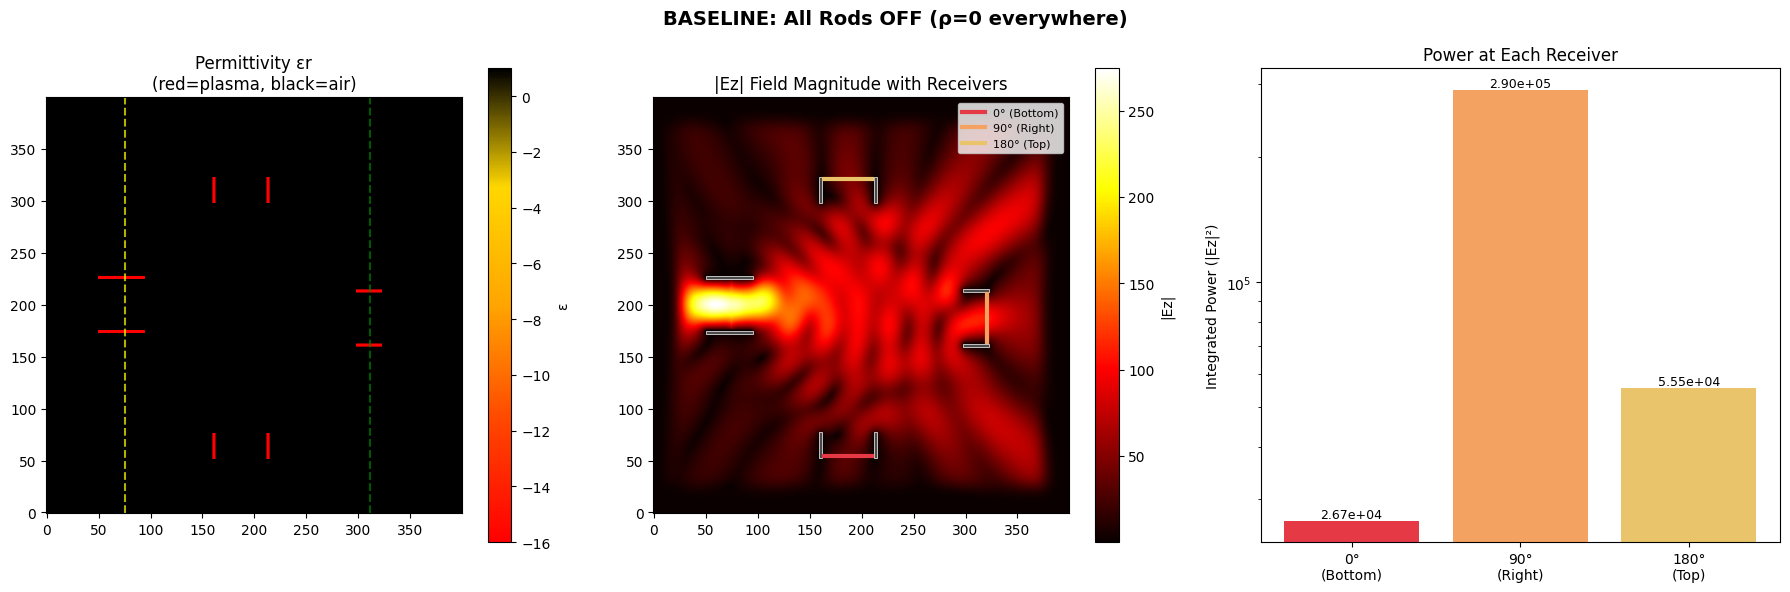


Baseline powers (all rods OFF):
    0°: 2.67e+04
   90°: 2.90e+05
  180°: 5.55e+04


In [94]:
# Test receivers with ALL RODS OFF (baseline - wave goes straight through)
print("=" * 70)
print("TEST: Receivers with ALL RODS OFF (expect most power at 90°)")
print("=" * 70)

test_rods_baseline = np.zeros((N_RODS, N_RODS))

# Run simulation and visualize with 3-panel display
Ez_baseline, eps_baseline, powers_baseline = visualize_simulation(
    test_rods_baseline, 
    title="BASELINE: All Rods OFF (ρ=0 everywhere)"
)

print(f"\nBaseline powers (all rods OFF):")
for angle, power in powers_baseline.items():
    print(f"  {angle:3d}°: {power:.2e}")


TEST: Asymmetric pattern (bottom half ON) - should deflect beam upward?
--- Simulation Call ---
  Input wave: f = 6.00 GHz, λ = 5.00 cm
  Rod ρ range: [0.00, 0.80] → ε range: [-3.00, 1.00]
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


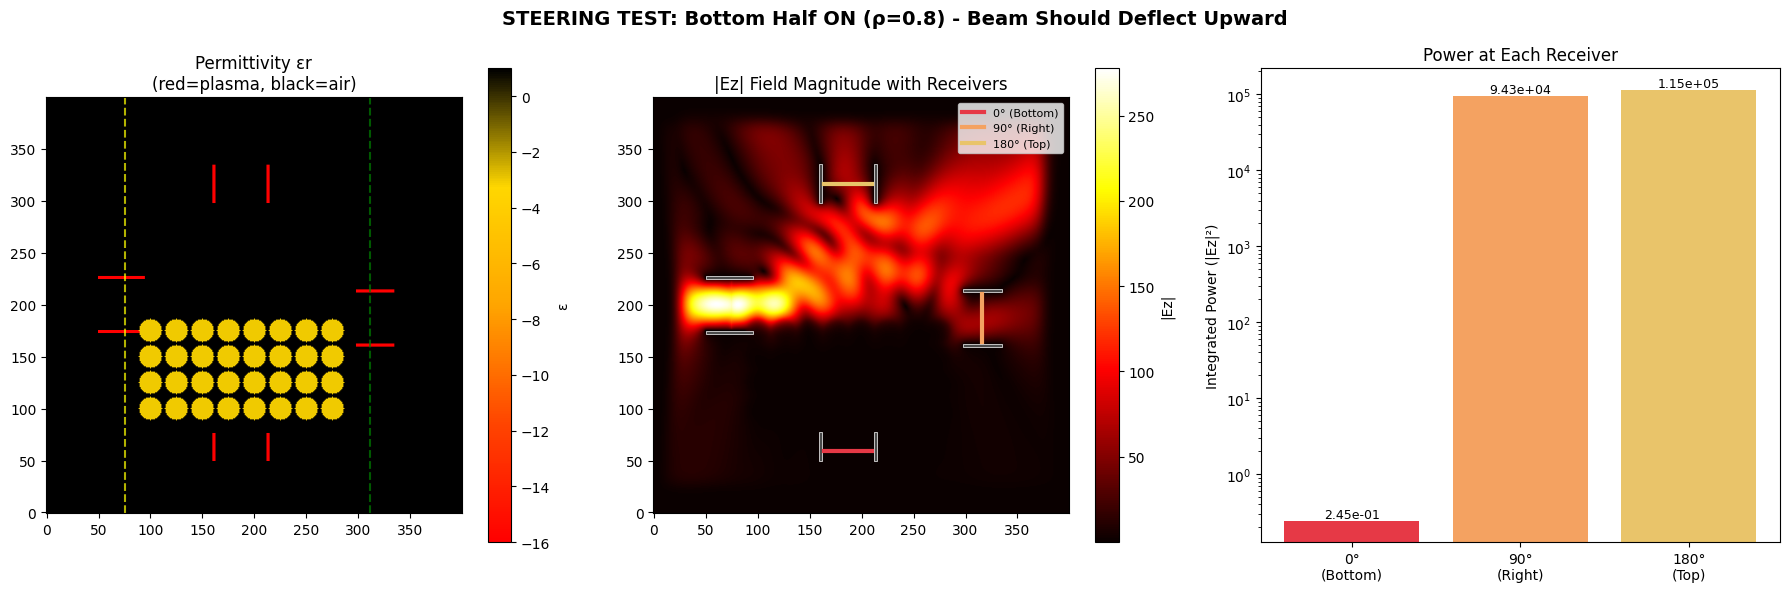


Steering powers (bottom half ON):
    0°: 2.45e-01  (ratio to baseline: 0.00x)
   90°: 9.43e+04  (ratio to baseline: 0.33x)
  180°: 1.15e+05  (ratio to baseline: 2.09x)


In [90]:
# Test with asymmetric rod pattern to see if steering affects receiver powers
print("=" * 70)
print("TEST: Asymmetric pattern (bottom half ON) - should deflect beam upward?")
print("=" * 70)

test_rods_steer = np.zeros((N_RODS, N_RODS))
test_rods_steer[:, 0:4] = 0.8  # Bottom half of rods ON (columns 0-3)

# Run simulation and visualize with 3-panel display
Ez_steer, eps_steer, powers_steer = visualize_simulation(
    test_rods_steer,
    title="STEERING TEST: Bottom Half ON (ρ=0.8) - Beam Should Deflect Upward"
)

print(f"\nSteering powers (bottom half ON):")
for angle, power in powers_steer.items():
    ratio = power / powers_baseline[angle]
    print(f"  {angle:3d}°: {power:.2e}  (ratio to baseline: {ratio:.2f}x)")


## Test: Run Simulation with Random Rod Pattern

Test the complete simulation pipeline with continuous ρ values.

Test rod pattern (ρ values):
[[0.86 0.8  0.59 0.77 0.22 0.88 0.29 0.15]
 [0.33 0.38 0.32 0.2  0.53 0.43 0.29 0.35]
 [0.91 0.24 0.76 0.8  0.18 0.55 0.46 0.2 ]
 [0.24 0.01 0.83 0.88 0.84 0.25 0.63 0.3 ]
 [0.   0.91 0.22 0.48 0.19 0.83 0.58 0.69]
 [0.63 0.65 0.57 0.84 0.66 0.15 0.31 0.6 ]
 [0.15 0.07 0.04 0.54 0.42 0.88 0.36 0.14]
 [0.4  0.58 0.58 0.23 0.52 0.32 0.71 0.93]]
--- Simulation Call ---
  Input wave: f = 6.00 GHz, λ = 5.00 cm
  Rod ρ range: [0.00, 0.93] → ε range: [-4.40, 1.00]
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


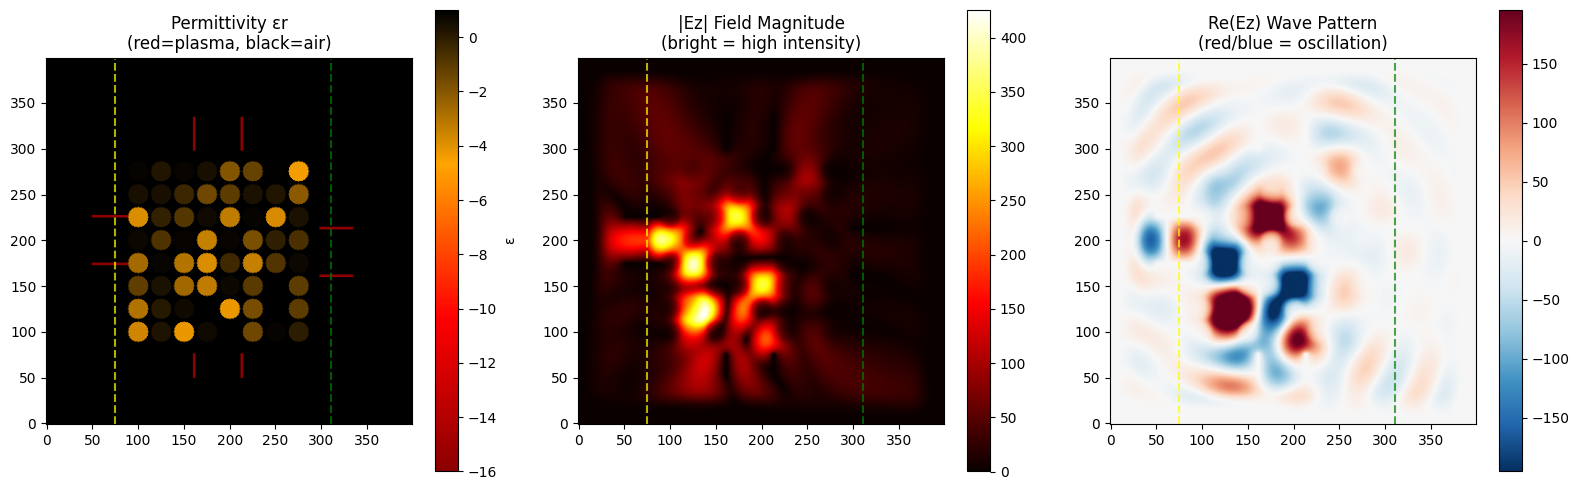


Simulation completed!
  Ez field shape: (400, 400)
  Permittivity shape: (400, 400)
  |Ez| range: [2.195e-08, 4.255e+02]


In [82]:
# Test with random continuous rod states (ρ values between 0 and 1)
# np.random.seed(29)  # For reproducibility
test_rods = np.random.rand(N_RODS, N_RODS)

print(f"Test rod pattern (ρ values):")
print(test_rods.round(2))

# Run simulation with visualization
Ez, eps = run_simulation(test_rods, visualize=True)

print(f"\nSimulation completed!")
print(f"  Ez field shape: {Ez.shape}")
print(f"  Permittivity shape: {eps.shape}")
print(f"  |Ez| range: [{np.abs(Ez).min():.3e}, {np.abs(Ez).max():.3e}]")

Testing with ALL RODS OFF (ρ=0 everywhere):
--- Simulation Call ---
  Input wave: f = 6.00 GHz, λ = 5.00 cm
  Rod ρ range: [0.00, 0.00] → ε range: [1.00, 1.00]
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


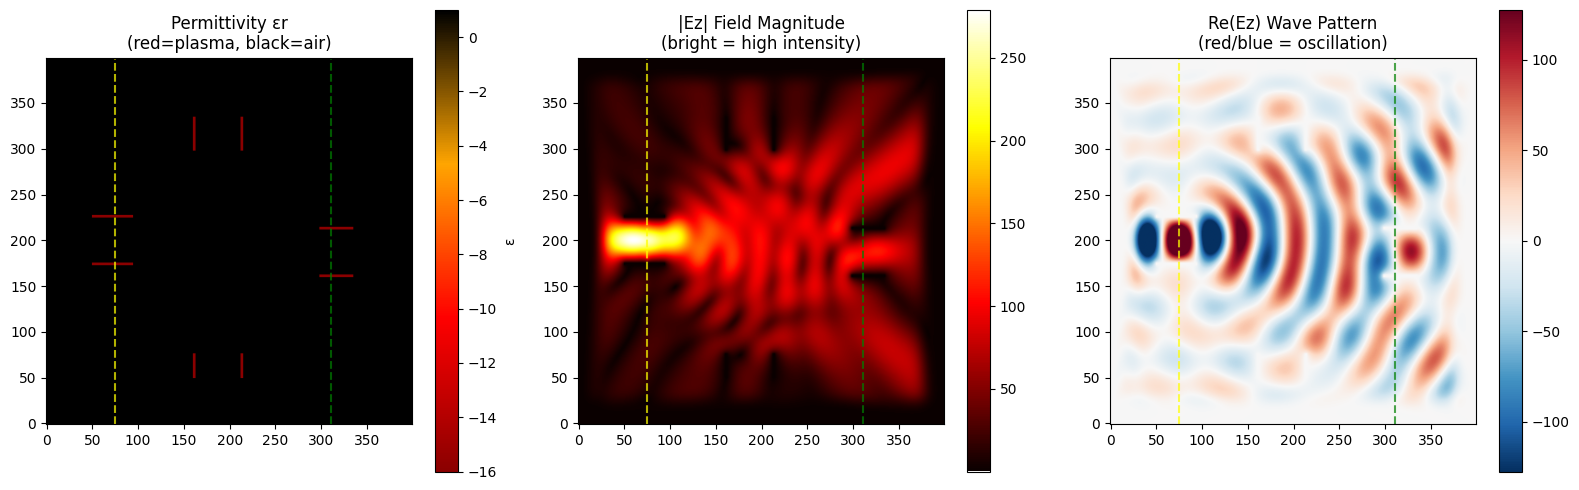

|Ez| range: [9.610e-08, 2.790e+02]


In [83]:
# Debug: Test with ALL RODS OFF to see if wave propagates through empty space
test_rods_off = np.zeros((N_RODS, N_RODS))

print("Testing with ALL RODS OFF (ρ=0 everywhere):")
Ez_off, eps_off = run_simulation(test_rods_off, visualize=True)

print(f"|Ez| range: [{np.abs(Ez_off).min():.3e}, {np.abs(Ez_off).max():.3e}]")

Testing with upper-left quadrant ON (ρ=0.8):
[[0.8 0.8 0.8 0.8 0.  0.  0.  0. ]
 [0.8 0.8 0.8 0.8 0.  0.  0.  0. ]
 [0.8 0.8 0.8 0.8 0.  0.  0.  0. ]
 [0.8 0.8 0.8 0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]
--- Simulation Call ---
  Input wave: f = 6.00 GHz, λ = 5.00 cm
  Rod ρ range: [0.00, 0.80] → ε range: [-3.00, 1.00]
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


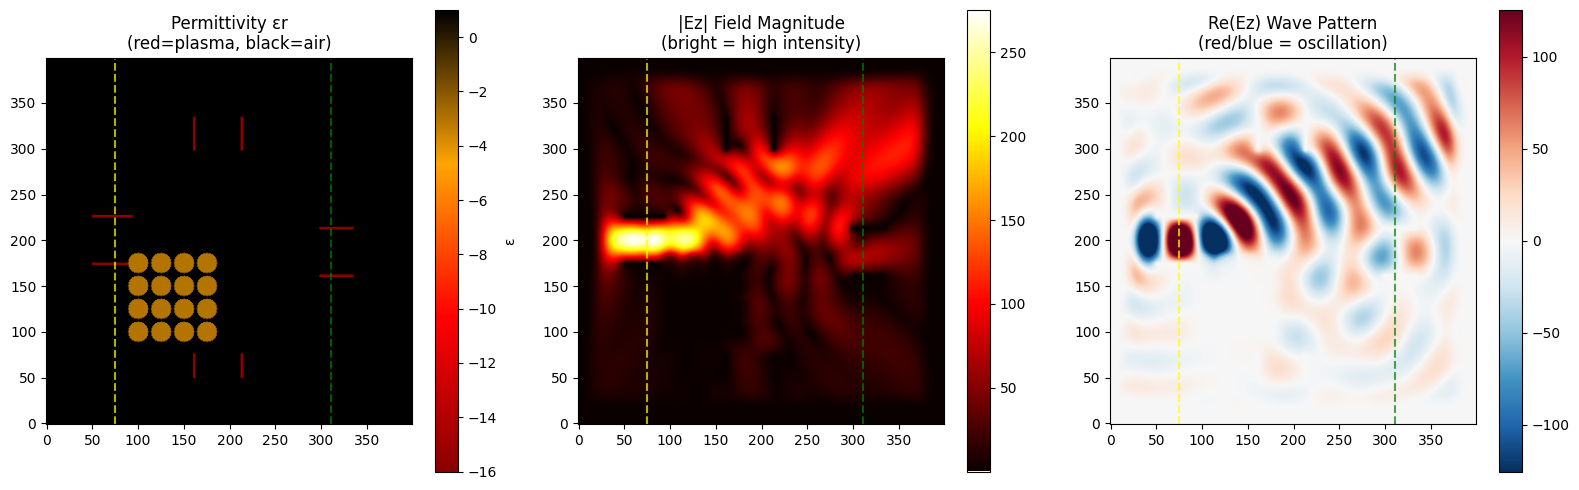

In [84]:
# Test with a simple pattern: only a few rods ON to see steering effect
test_pattern = np.zeros((N_RODS, N_RODS))

# Turn on just a few rods on one side to try to deflect the beam
test_pattern[0:4, 0:4] = 0.8  # Upper-left quadrant ON

print("Testing with upper-left quadrant ON (ρ=0.8):")
print(test_pattern)
Ez_test, eps_test = run_simulation(test_pattern, visualize=True)

## Frequency Selection Analysis

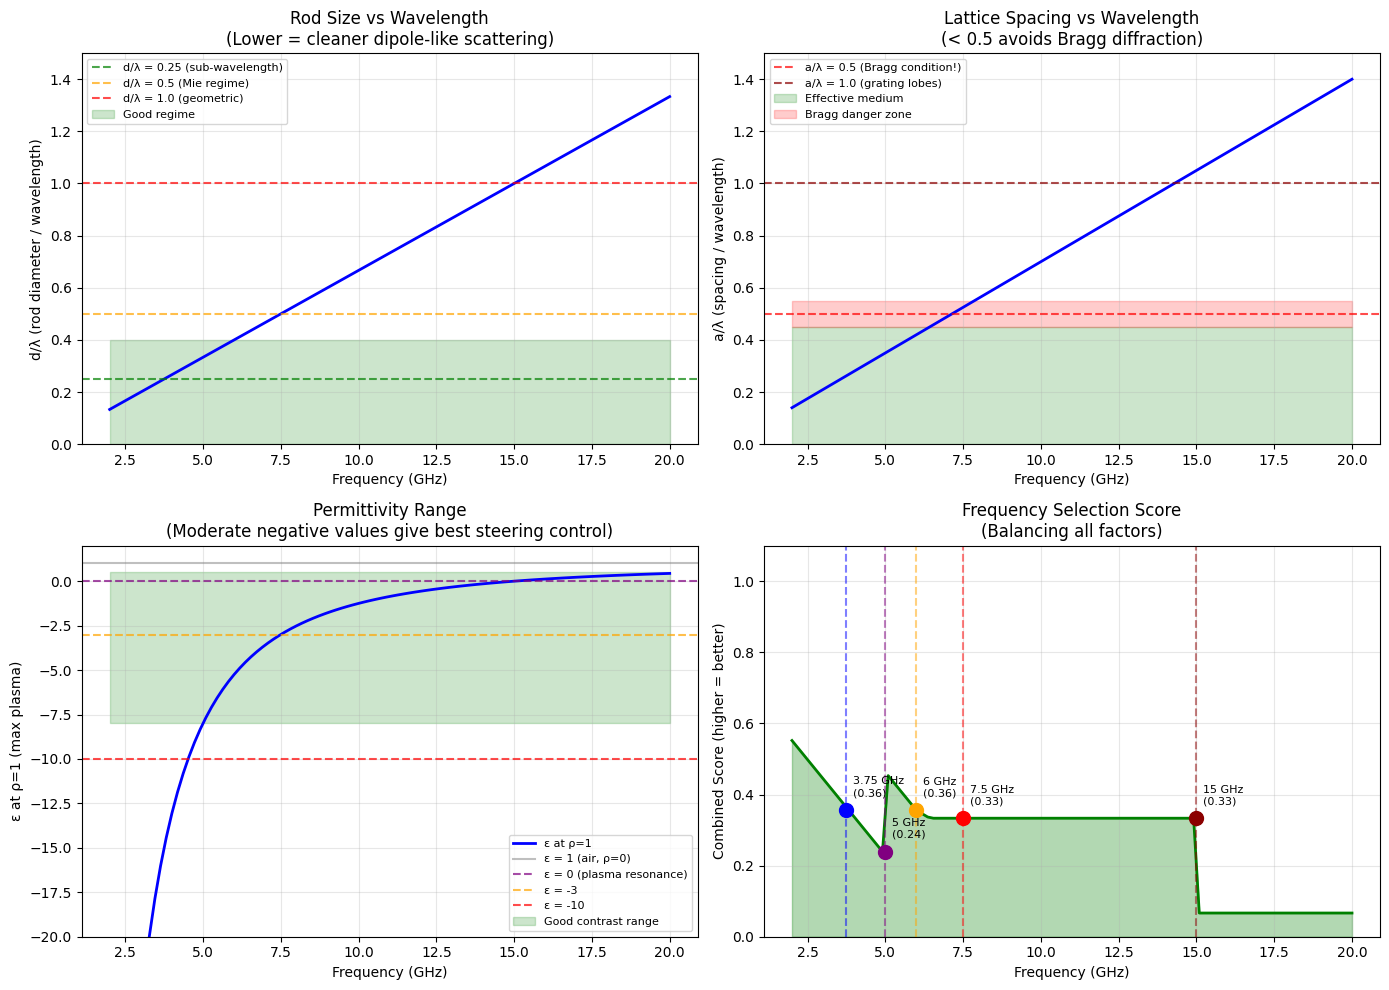


FREQUENCY SELECTION SUMMARY
Freq (GHz)   λ (cm)     d/λ        a/λ        ε(ρ=1)       Score      Notes
--------------------------------------------------------------------------------
3.00         10.0       0.20       0.21       -24.0        0.45       extreme ε
3.75         8.0        0.25       0.26       -15.0        0.36       extreme ε
5.00         6.0        0.33       0.35       -8.0         0.24       
6.00         5.0        0.40       0.42       -5.2         0.36       ✓ GOOD
7.50         4.0        0.50       0.53       -3.0         0.33       ⚠️ BRAGG
10.00        3.0        0.67       0.70       -1.2         0.33       rod too big, grating lobes
15.00        2.0        1.00       1.05       0.0          0.33       rod too big, grating lobes

>>> RECOMMENDATION: 5-6 GHz range offers best balance of:
    - Sub-wavelength rods (d/λ ≈ 0.33-0.4)
    - Safe from Bragg diffraction (a/λ ≈ 0.35-0.42)
    - Strong but not extreme permittivity contrast (ε ≈ -5 to -8)


In [52]:
# =============================================================================
# FREQUENCY SELECTION ANALYSIS
# =============================================================================
# Explore trade-offs for choosing operating frequency given fixed hardware:
#   - Rod diameter: 2 cm
#   - Rod spacing: 2.1 cm  
#   - Max plasma frequency: 15 GHz

# Fixed hardware parameters
d = 0.02      # rod diameter (m)
a_spacing = 0.021   # lattice constant (m)
array_size = 8 * a_spacing  # total array size (m)
omega_p_max = 15e9  # max plasma frequency (Hz)
c = 3e8       # speed of light (m/s)

# Frequency range to explore
frequencies = np.linspace(2, 20, 100)  # GHz

# Compute metrics for each frequency
wavelengths = c / (frequencies * 1e9)
d_over_lambda = d / wavelengths
a_over_lambda = a_spacing / wavelengths
array_over_lambda = array_size / wavelengths
# Drude model: ε = 1 - (ω_p/ω)² = 1 - (f_p/f)²
eps_at_rho_1 = 1 - (omega_p_max / (frequencies * 1e9))**2  # permittivity at max plasma

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: d/λ (rod size vs wavelength)
ax1 = axes[0, 0]
ax1.plot(frequencies, d_over_lambda, 'b-', linewidth=2)
ax1.axhline(0.25, color='green', linestyle='--', alpha=0.7, label='d/λ = 0.25 (sub-wavelength)')
ax1.axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='d/λ = 0.5 (Mie regime)')
ax1.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='d/λ = 1.0 (geometric)')
ax1.fill_between(frequencies, 0, 0.4, alpha=0.2, color='green', label='Good regime')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('d/λ (rod diameter / wavelength)')
ax1.set_title('Rod Size vs Wavelength\n(Lower = cleaner dipole-like scattering)')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.5)

# Plot 2: a/λ (lattice spacing vs wavelength)
ax2 = axes[0, 1]
ax2.plot(frequencies, a_over_lambda, 'b-', linewidth=2)
ax2.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='a/λ = 0.5 (Bragg condition!)')
ax2.axhline(1.0, color='darkred', linestyle='--', alpha=0.7, label='a/λ = 1.0 (grating lobes)')
ax2.fill_between(frequencies, 0, 0.45, alpha=0.2, color='green', label='Effective medium')
ax2.fill_between(frequencies, 0.45, 0.55, alpha=0.2, color='red', label='Bragg danger zone')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('a/λ (spacing / wavelength)')
ax2.set_title('Lattice Spacing vs Wavelength\n(< 0.5 avoids Bragg diffraction)')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.5)

# Plot 3: Permittivity range
ax3 = axes[1, 0]
ax3.plot(frequencies, eps_at_rho_1, 'b-', linewidth=2, label='ε at ρ=1')
ax3.axhline(1.0, color='gray', linestyle='-', alpha=0.5, label='ε = 1 (air, ρ=0)')
ax3.axhline(0.0, color='purple', linestyle='--', alpha=0.7, label='ε = 0 (plasma resonance)')
ax3.axhline(-3, color='orange', linestyle='--', alpha=0.7, label='ε = -3')
ax3.axhline(-10, color='red', linestyle='--', alpha=0.7, label='ε = -10')
ax3.fill_between(frequencies, -8, 0.5, alpha=0.2, color='green', label='Good contrast range')
ax3.set_xlabel('Frequency (GHz)')
ax3.set_ylabel('ε at ρ=1 (max plasma)')
ax3.set_title('Permittivity Range\n(Moderate negative values give best steering control)')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-20, 2)

# Plot 4: Summary recommendation
ax4 = axes[1, 1]
# Score: penalize d/λ > 0.4, a/λ near 0.5, and extreme permittivity
score = np.zeros_like(frequencies)
# Prefer d/λ < 0.4
score += np.clip(0.4 - d_over_lambda, 0, 0.4) / 0.4
# Prefer a/λ < 0.45 (away from Bragg)
score += np.clip(0.45 - a_over_lambda, 0, 0.45) / 0.45
# Prefer -8 < ε < 0 (good contrast without being extreme)
eps_score = np.where((eps_at_rho_1 > -8) & (eps_at_rho_1 < 0), 1.0,
            np.where((eps_at_rho_1 >= 0), 0.2, 0.3))  # penalize positive (weak) or very negative (extreme)
score += eps_score
score = score / 3  # normalize to [0, 1]

ax4.plot(frequencies, score, 'g-', linewidth=2)
ax4.fill_between(frequencies, 0, score, alpha=0.3, color='green')

# Mark key frequencies
for f, label, color in [(3.75, '3.75 GHz', 'blue'), 
                         (5.0, '5 GHz', 'purple'),
                         (6.0, '6 GHz', 'orange'),
                         (7.5, '7.5 GHz', 'red'),
                         (15.0, '15 GHz', 'darkred')]:
    idx = np.argmin(np.abs(frequencies - f))
    ax4.axvline(f, color=color, linestyle='--', alpha=0.5)
    ax4.scatter([f], [score[idx]], color=color, s=100, zorder=5)
    ax4.annotate(f'{label}\n({score[idx]:.2f})', (f, score[idx]), 
                 textcoords='offset points', xytext=(5, 10), fontsize=8)

ax4.set_xlabel('Frequency (GHz)')
ax4.set_ylabel('Combined Score (higher = better)')
ax4.set_title('Frequency Selection Score\n(Balancing all factors)')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("FREQUENCY SELECTION SUMMARY")
print("=" * 80)
print(f"{'Freq (GHz)':<12} {'λ (cm)':<10} {'d/λ':<10} {'a/λ':<10} {'ε(ρ=1)':<12} {'Score':<10} {'Notes'}")
print("-" * 80)
for f in [3.0, 3.75, 5.0, 6.0, 7.5, 10.0, 15.0]:
    lam = c / (f * 1e9) * 100  # cm
    d_l = d / (c / (f * 1e9))
    a_l = a_spacing / (c / (f * 1e9))
    eps = 1 - (omega_p_max / (f * 1e9))**2  # Fixed: convert f to Hz
    idx = np.argmin(np.abs(frequencies - f))
    s = score[idx]
    
    notes = []
    if d_l > 0.5: notes.append("rod too big")
    if a_l > 0.45 and a_l < 0.55: notes.append("⚠️ BRAGG")
    if a_l > 0.55: notes.append("grating lobes")
    if eps < -10: notes.append("extreme ε")
    if eps > 0: notes.append("weak contrast")
    if 0.25 < d_l < 0.4 and a_l < 0.45 and -8 < eps < -2: notes.append("✓ GOOD")
    
    print(f"{f:<12.2f} {lam:<10.1f} {d_l:<10.2f} {a_l:<10.2f} {eps:<12.1f} {s:<10.2f} {', '.join(notes)}")

print("=" * 80)
print("\n>>> RECOMMENDATION: 5-6 GHz range offers best balance of:")
print("    - Sub-wavelength rods (d/λ ≈ 0.33-0.4)")
print("    - Safe from Bragg diffraction (a/λ ≈ 0.35-0.42)")  
print("    - Strong but not extreme permittivity contrast (ε ≈ -5 to -8)")
